In [274]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    make_scorer
)
import matplotlib.pyplot as plt
from sklearn import tree
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from IPython.display import FileLink

In [5]:
df_new = pd.read_csv('../CSV/df_new.csv', low_memory=False)

df = pd.read_csv('../CSV/df.csv', low_memory=False)

# Set display option to show all columns
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

In [15]:
df_new

,NAICS_U.S._Industry_Title,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status,Month_Of_Approval
0,RetailTrade,84,4,New,Unknown,0,1,60000,1,Midwest,0,February
1,Accommodation_FoodServices,60,2,New,Unknown,0,1,40000,1,Midwest,0,February
2,HealthCare_SocialAssistance,180,7,Existing,Unknown,0,0,287000,1,Midwest,0,February
3,Unknown,60,2,Existing,Unknown,0,1,35000,1,South,0,February
4,Unknown,240,14,Existing,Unknown,0,0,229000,1,South,0,February
...,...,...,...,...,...,...,...,...,...,...,...,...
872914,RetailTrade,60,6,Existing,Unknown,0,0,70000,1,Midwest,0,February
872915,RetailTrade,60,6,Existing,Unknown,1,0,85000,1,Midwest,0,February
872916,Manufacturing,108,26,Existing,Unknown,0,0,300000,1,West,0,February
872917,Unknown,60,6,Existing,Unknown,0,1,75000,0,West,0,February


#### Dropping Unnecessary Columns: NAICS_U.S._Industry_Title, Business_Type, Urban_Rural_Status

Dropping the columns **NAICS_U.S._Industry_Title**, **Business_Type**, and **Urban_Rural_Status** to test if their removal improves model performance for tree-based algorithms. This step may help reduce noise and prevent overfitting by eliminating potentially redundant or non-informative features.

In [9]:
columns_drop = ['NAICS_U.S._Industry_Title', 'Business_Type', 'Urban_Rural_Status']
df_new_dropped = df_new.drop(columns = columns_drop)

In [11]:
df_new_dropped

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status,Month_Of_Approval
0,84,4,0,1,60000,1,Midwest,0,February
1,60,2,0,1,40000,1,Midwest,0,February
2,180,7,0,0,287000,1,Midwest,0,February
3,60,2,0,1,35000,1,South,0,February
4,240,14,0,0,229000,1,South,0,February
...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,Midwest,0,February
872915,60,6,1,0,85000,1,Midwest,0,February
872916,108,26,0,0,300000,1,West,0,February
872917,60,6,0,1,75000,0,West,0,February


#### Dummy Encoding

We are using **dummy encoding** to transform categorical variables into numerical representations suitable for machine learning models. This process converts categories into binary (0 or 1) columns, allowing algorithms like logistic regression to process the data effectively. Dummy variables help maintain the interpretability of categorical data while ensuring compatibility with numerical modeling techniques.

**Why Certain Columns Are Excluded**

The following columns are excluded from dummy encoding:
- **Loan_Term**, **Number_Of_Employees**, **Disbursement_Gross**: These columns are numerical and do not require encoding.
- **Revolving_Line_Of_Credit**, **Low_Documentation_Loan_Program**: These columns already contain binary values (0 and 1) and do not need further transformation.
- **Loan_Status**: This column is the target variable (dependent variable) for our logistic regression model and should not be transformed.

By excluding these columns, we ensure that the essential structure of the data remains intact while focusing on converting only the necessary categorical features into dummy variables.

In [24]:
# Specify columns to exclude from dummy encoding
exclude_columns = [
    'Loan_Term', 
    'Number_Of_Employees', 
    'Revolving_Line_Of_Credit', 
    'Low_Documentation_Loan_Program', 
    'Disbursement_Gross', 
    'Loan_Status'
]

# Create dummy variables for all columns except those in exclude_columns
df_new_dummies = pd.get_dummies(df_new, columns=[col for col in df_new.columns if col not in exclude_columns], drop_first=True)

df_new_dropped_dummies = pd.get_dummies(df_new_dropped, columns=[col for col in df_new_dropped.columns if col not in exclude_columns], drop_first=True)

# Convert boolean columns to integer values (0 and 1)
for col in df_new_dummies.select_dtypes(include=['bool']).columns:
    df_new_dummies[col] = df_new_dummies[col].astype(int)

for col in df_new_dropped_dummies.select_dtypes(include=['bool']).columns:
    df_new_dropped_dummies[col] = df_new_dropped_dummies[col].astype(int)

In [28]:
df_new_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,NAICS_U.S._Industry_Title_Administrative&Support_WasteManagement_RemediationServices,NAICS_U.S._Industry_Title_Agriculture_Forestry_Fishing_Hunting,NAICS_U.S._Industry_Title_Arts_Entertainment_Recreation,NAICS_U.S._Industry_Title_Construction,NAICS_U.S._Industry_Title_Educational,NAICS_U.S._Industry_Title_Finance_Insurance,NAICS_U.S._Industry_Title_HealthCare_SocialAssistance,NAICS_U.S._Industry_Title_Information,NAICS_U.S._Industry_Title_ManagementOfCompaniesAndEnterprises,NAICS_U.S._Industry_Title_Manufacturing,NAICS_U.S._Industry_Title_Mining_Quarrying_Oil&GasExtraction,NAICS_U.S._Industry_Title_OtherServices(except Public Administration),NAICS_U.S._Industry_Title_Professional_Scientific_TechService,NAICS_U.S._Industry_Title_PublicAdministration,NAICS_U.S._Industry_Title_RealEstate_Rental_Leasing,NAICS_U.S._Industry_Title_RetailTrade,NAICS_U.S._Industry_Title_Transportation_Warehousing,NAICS_U.S._Industry_Title_Unknown,NAICS_U.S._Industry_Title_Utilities,NAICS_U.S._Industry_Title_WholesaleTrade,Business_Type_New,Business_Type_Unknown,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West,Franchise_Status_1,Month_Of_Approval_August,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
0,84,4,0,1,60000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60,2,0,1,40000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,180,7,0,0,287000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,60,2,0,1,35000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,240,14,0,0,229000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872915,60,6,1,0,85000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872916,108,26,0,0,300000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
872917,60,6,0,1,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [26]:
df_new_dropped_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region_Northeast,Region_South,Region_West,Franchise_Status_1,Month_Of_Approval_August,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
0,84,4,0,1,60000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60,2,0,1,40000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,180,7,0,0,287000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,60,2,0,1,35000,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,240,14,0,0,229000,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872915,60,6,1,0,85000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872916,108,26,0,0,300000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
872917,60,6,0,1,75000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


#### Single Decision Tree Classifier

I chose to use the Gini index as the criterion for the decision tree, as it provided the best performance compared to other options. The key decisions made to optimize model performance include:
- **Max Depth of 20:** This limit helps prevent overfitting. If the depth were any greater, the model would start to capture noise in the data, leading to overfitting.
- **Max Leaf Nodes = 150:** This further controls the complexity of the tree, reducing the risk of overfitting while still allowing enough flexibility to model the data effectively.
- **Class Weight = 'balanced':** Given the class imbalance between 'chargeoff' and 'paid in full', balancing the class weights ensures that the model pays appropriate attention to both classes and avoids bias toward the majority class.

We will now test the single decision tree classifier on both datasets, **df_new_dummies** and **df_new_dropped_dummies**, to evaluate their performance and compare the impact of including or excluding certain features on model accuracy and generalization. This will allow us to determine which dataset yields better results for the task at hand.

Training Set Metrics:
Accuracy: 0.9011
Precision: 0.9788
Recall: 0.9003
F1 Score: 0.9379

Test Set Metrics:
Accuracy: 0.8998
Precision: 0.9781
Recall: 0.8993
F1 Score: 0.9370

Specificity (Training Set): 0.9054
Specificity (Test Set): 0.9022


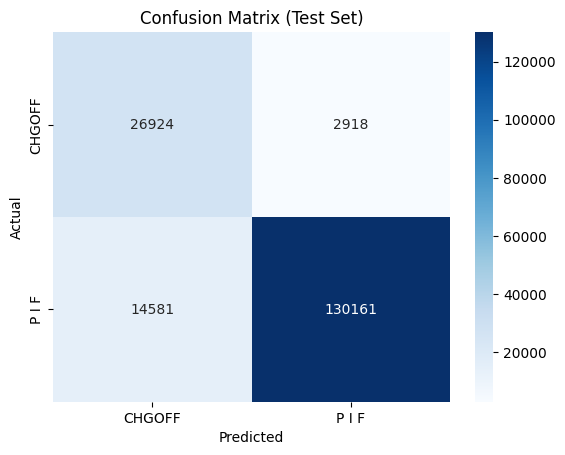

Total Net Profit/Loss: 1270063070.70
Average Total Net Profit/Loss: 7274.80


In [31]:
# Split data into features and target
X = df_new_dummies.drop('Loan_Status', axis=1)
y = df_new_dummies['Loan_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=20,
    random_state=42,
    max_leaf_nodes=150,
    class_weight='balanced',
)
clf.fit(X_train, y_train)

# Make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

# Evaluate on training set
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

# Evaluate on test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Profit/Loss Calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

# Ensure Disbursement_Gross is present
if 'Disbursement_Gross' in df_new.columns:
    df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)
else:
    raise ValueError("Column 'Disbursement_Gross' is missing in 'df_new'")

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate average profit/loss
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Training Set Metrics:
Accuracy: 0.9057
Precision: 0.9785
Recall: 0.9062
F1 Score: 0.9409

Test Set Metrics:
Accuracy: 0.9042
Precision: 0.9781
Recall: 0.9047
F1 Score: 0.9400

Specificity (Training Set): 0.9034
Specificity (Test Set): 0.9016


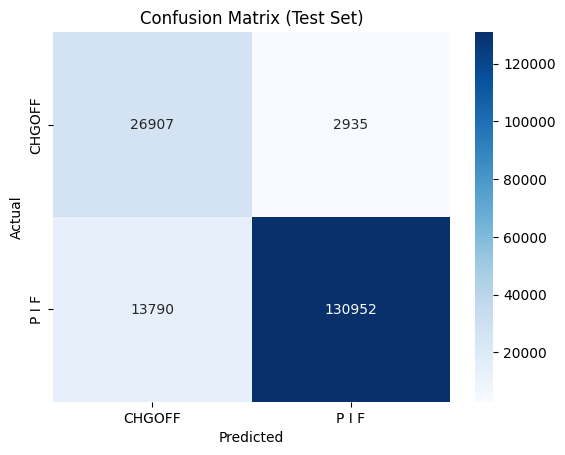

Total Net Profit/Loss: 1293094098.05
Average Total Net Profit/Loss: 7406.72


In [33]:
# Split data into features and target
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=20,
    random_state=42,
    max_leaf_nodes=150,
    class_weight='balanced',
)
clf.fit(X_train, y_train)

# Make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

# Evaluate on training set
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

# Evaluate on test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Profit/Loss Calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

# Ensure Disbursement_Gross is present
if 'Disbursement_Gross' in df_new.columns:
    df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)
else:
    raise ValueError("Column 'Disbursement_Gross' is missing in 'df_new'")

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate average profit/loss
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Both **df_new_dummies** and **df_new_dropped_dummies** performed well, with high profits. **df_new_dropped_dummies** achieved a higher profit of $7406.72.

Below is the decision tree for **df_new_dropped_dummies**. This tree visualizes the model's decision-making process after removing the specified columns. It shows how the features from the remaining data are used to split the dataset at each node, ultimately leading to the predicted outcomes. The structure of the tree reflects the relationships within the data and how the model identifies patterns to make decisions.

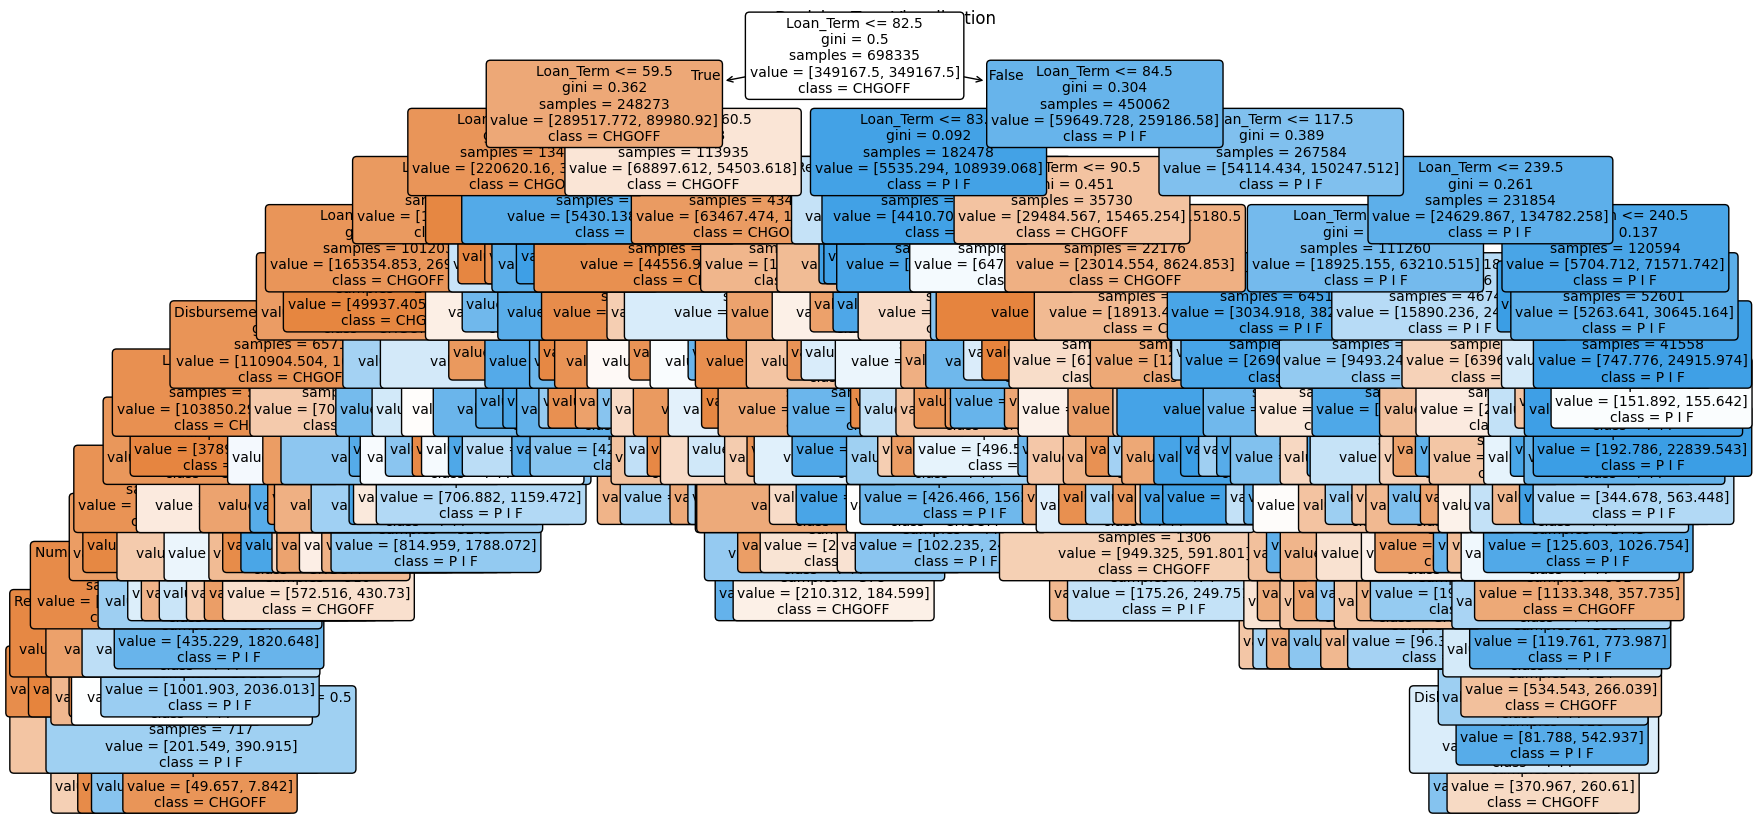

In [41]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['CHGOFF', 'P I F'],  # Replace with actual class names
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

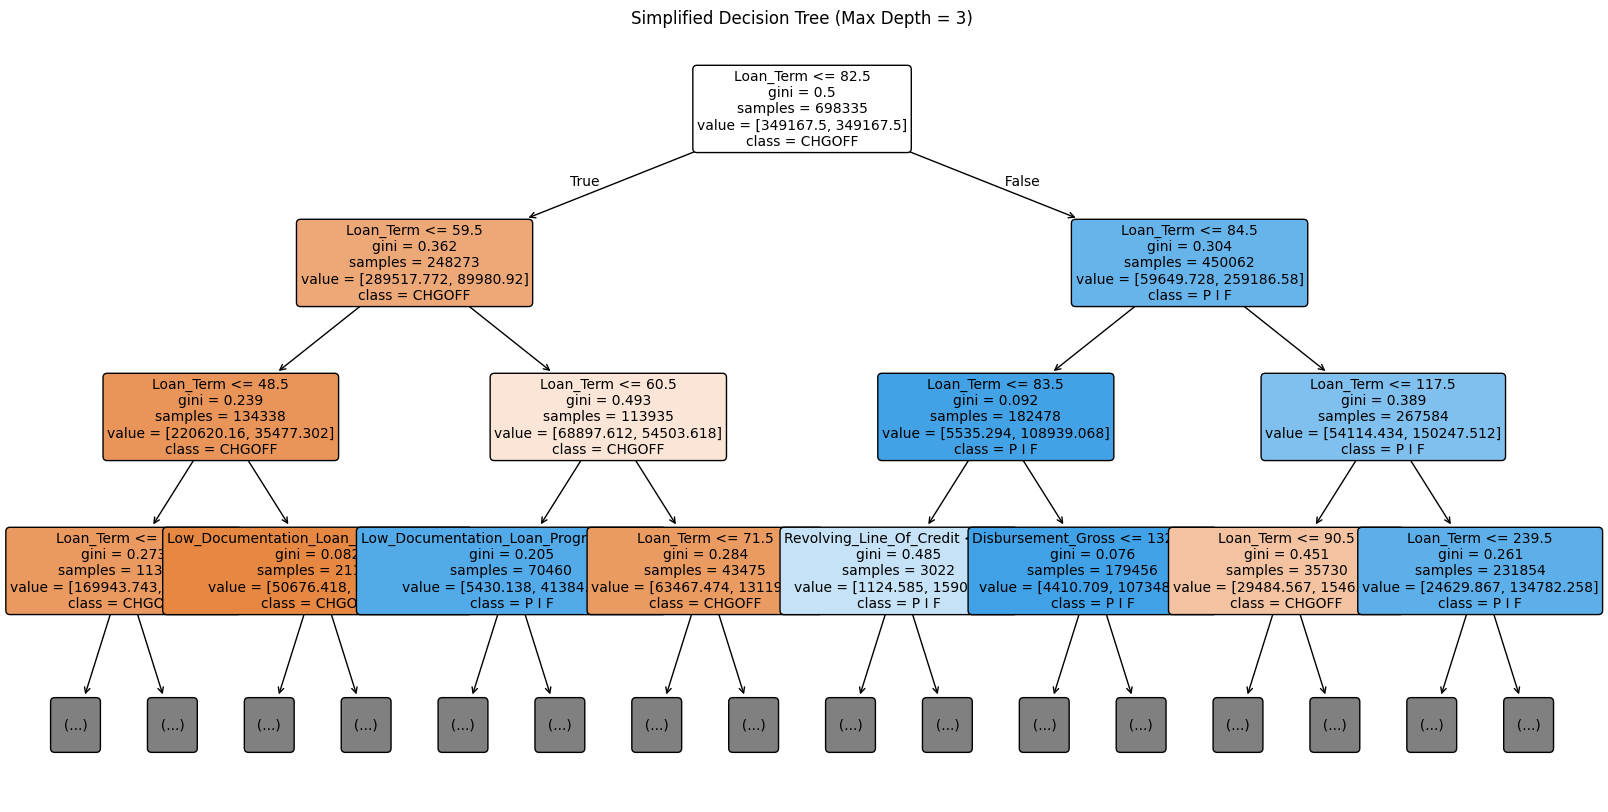

In [80]:
# Visualize the decision tree with limited depth
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['CHGOFF', 'P I F'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # Limit depth to 3
)
plt.title("Simplified Decision Tree (Max Depth = 3)")
plt.show()

#### Implementing Bagging with Random Forest

In this section, we will implement bagging using Random Forest. Key points include:
- **Ensemble Learning:** Random Forest combines multiple decision trees, improving accuracy by reducing variance and preventing overfitting.
- **Random Feature Selection:** Each tree is trained on a random subset of features, which helps promote diversity among trees and enhances model generalization.

**DecisionTreeClassifier:**
- **max_depth=20** and **max_leaf_nodes=150** limit tree complexity to prevent overfitting.
- **class_weight='balanced'** addresses class imbalance by adjusting weights for underrepresented classes.

**BaggingClassifier:**
- **n_estimators=50** ensures a strong ensemble by averaging over multiple trees.
- **bootstrap=True** enables bootstrapping, creating diverse data samples for each tree.
- **max_samples=0.8** and **max_features=0.7** introduce randomness, reducing overfitting and improving generalization.
- **oob_score=True** uses out-of-bag samples to estimate model performance without needing a validation set.

These parameters were chosen to enhance model performance, reduce overfitting, and ensure better generalization by balancing complexity, diversity, and bias.

Training Set Metrics:
Accuracy: 0.9081
Precision: 0.9788
Recall: 0.9087
F1 Score: 0.9425

Test Set Metrics:
Accuracy: 0.9070
Precision: 0.9786
Recall: 0.9078
F1 Score: 0.9418

Specificity (Training Set): 0.9050
Specificity (Test Set): 0.9033


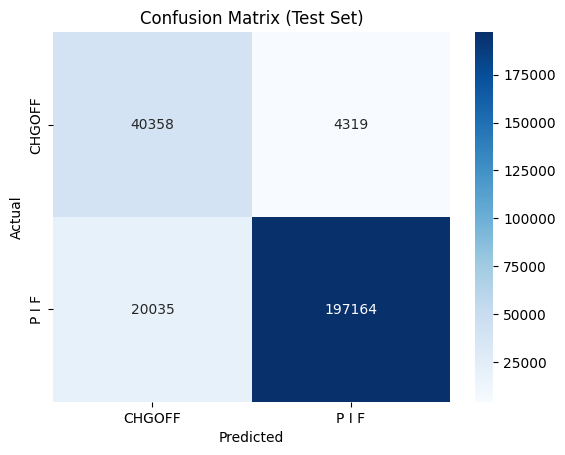

Total Net Profit/Loss: 1936905026.30
Average Total Net Profit/Loss: 7396.27


In [58]:
# Splitting the dataset
X = df_new_dummies.drop('Loan_Status', axis=1)
y = df_new_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Bagging Classifier with Decision Tree as base estimator
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=20,
        random_state=42,
        max_leaf_nodes=150,
        class_weight='balanced'
    ),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.7,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=True,
    random_state=42
)

# Fit the model
bagging_clf.fit(X_train, y_train)

# Evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

# Evaluate on training and test sets
y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Display metrics
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Confusion Matrix and Specificity
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Calculate specificity
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Profit/Loss Calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

# Ensure Disbursement_Gross is present
if 'Disbursement_Gross' in df_new.columns:
    df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)
else:
    raise ValueError("Column 'Disbursement_Gross' is missing in 'df_new'")

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate average profit/loss
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Training Set Metrics:
Accuracy: 0.9066
Precision: 0.9792
Recall: 0.9066
F1 Score: 0.9415

Test Set Metrics:
Accuracy: 0.9054
Precision: 0.9793
Recall: 0.9051
F1 Score: 0.9408

Specificity (Training Set): 0.9068
Specificity (Test Set): 0.9069


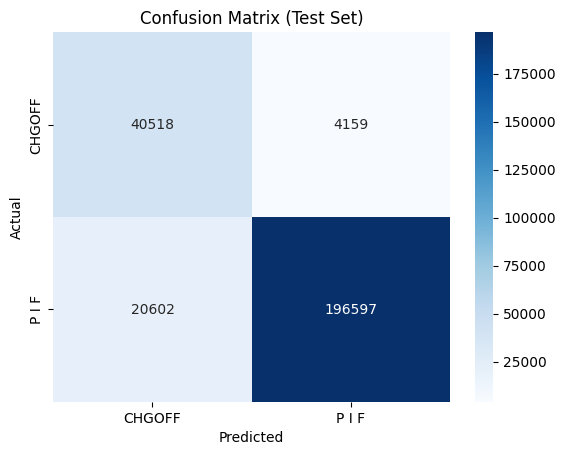

Total Net Profit/Loss: 1951532847.00
Average Total Net Profit/Loss: 7452.13


In [242]:
# Splitting the dataset
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Bagging Classifier with Decision Tree as base estimator
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=20,
        random_state=42,
        max_leaf_nodes=150,
        class_weight='balanced'
    ),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.7,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=True,
    random_state=42
)

# Fit the model
bagging_clf.fit(X_train, y_train)

# Evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

# Evaluate on training and test sets
y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Display metrics
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Confusion Matrix and Specificity
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Calculate specificity
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Profit/Loss Calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df.join(results)

df_combined = df_combined.join(df_new[['NAICS_U.S._Industry_Title']])

# Assuming you want to apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate average profit/loss
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

The dataset **df_new_dropped_dummies** once again outperformed **df_new_dummies**, demonstrating superior performance. Over the course of the analysis, **df_new_dropped_dummies** achieved an impressive average total net profit of $7452.13, surpassing the results generated by **df_new_dummies**. This reinforces the effectiveness of dropping certain dummy variables in optimizing the model’s performance, highlighting its ability to generate higher profitability in comparison to the alternative dataset.

Below is the decision tree for **df_new_dropped_dummies**. This tree visualizes the model's decision-making process after removing the specified columns. It shows how the features from the remaining data are used to split the dataset at each node, ultimately leading to the predicted outcomes. The structure of the tree reflects the relationships within the data and how the model identifies patterns to make decisions.

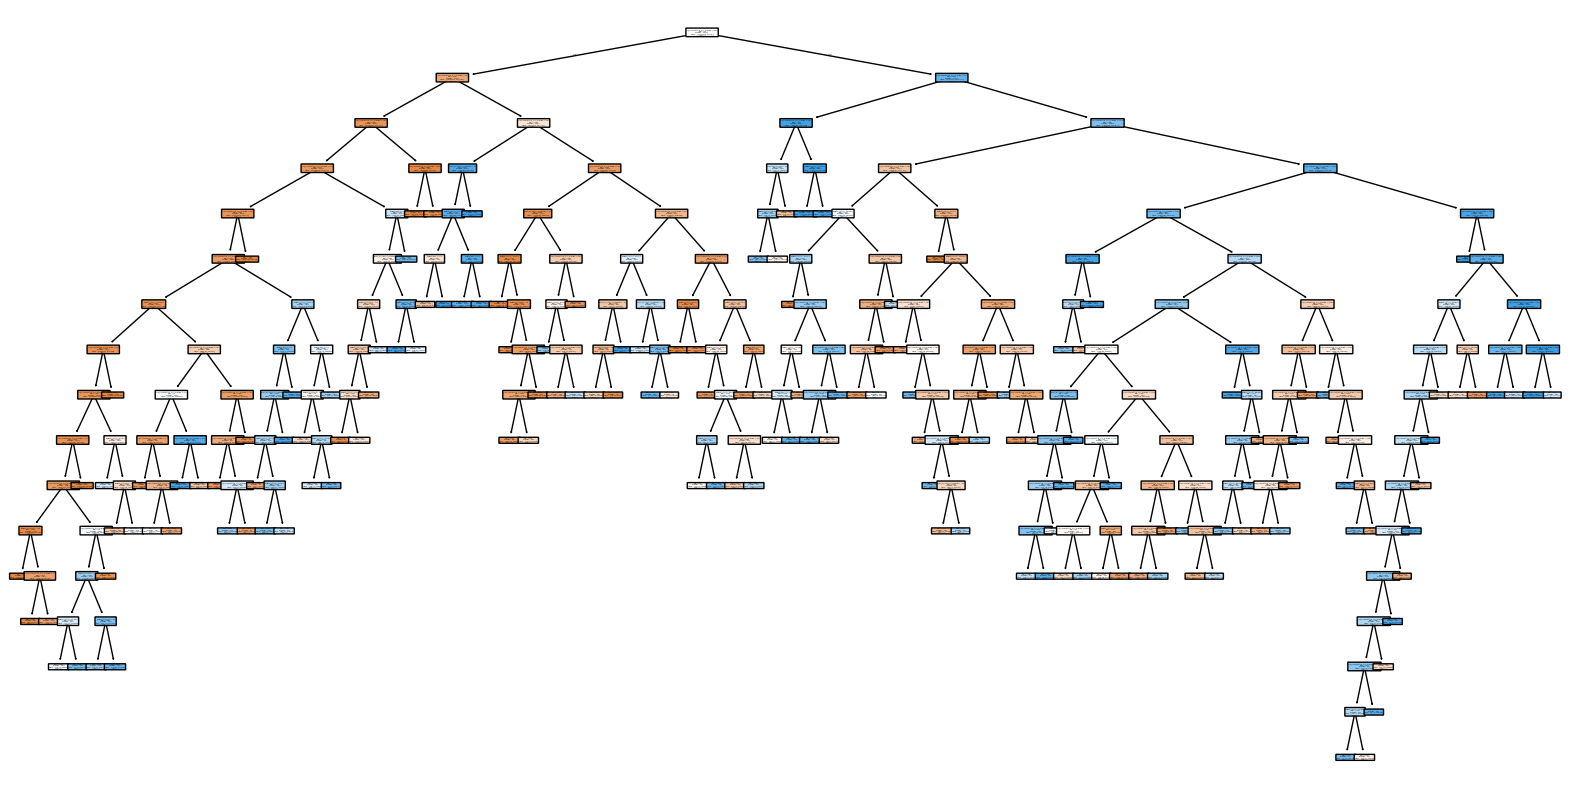

In [73]:
# Extract the first decision tree from the Bagging Classifier
first_tree = bagging_clf.estimators_[0]

# Plot the first decision tree
plt.figure(figsize=(20, 10))
plot_tree(first_tree, filled=True, feature_names=X.columns, class_names=y.unique().astype(str), rounded=True)
plt.show()

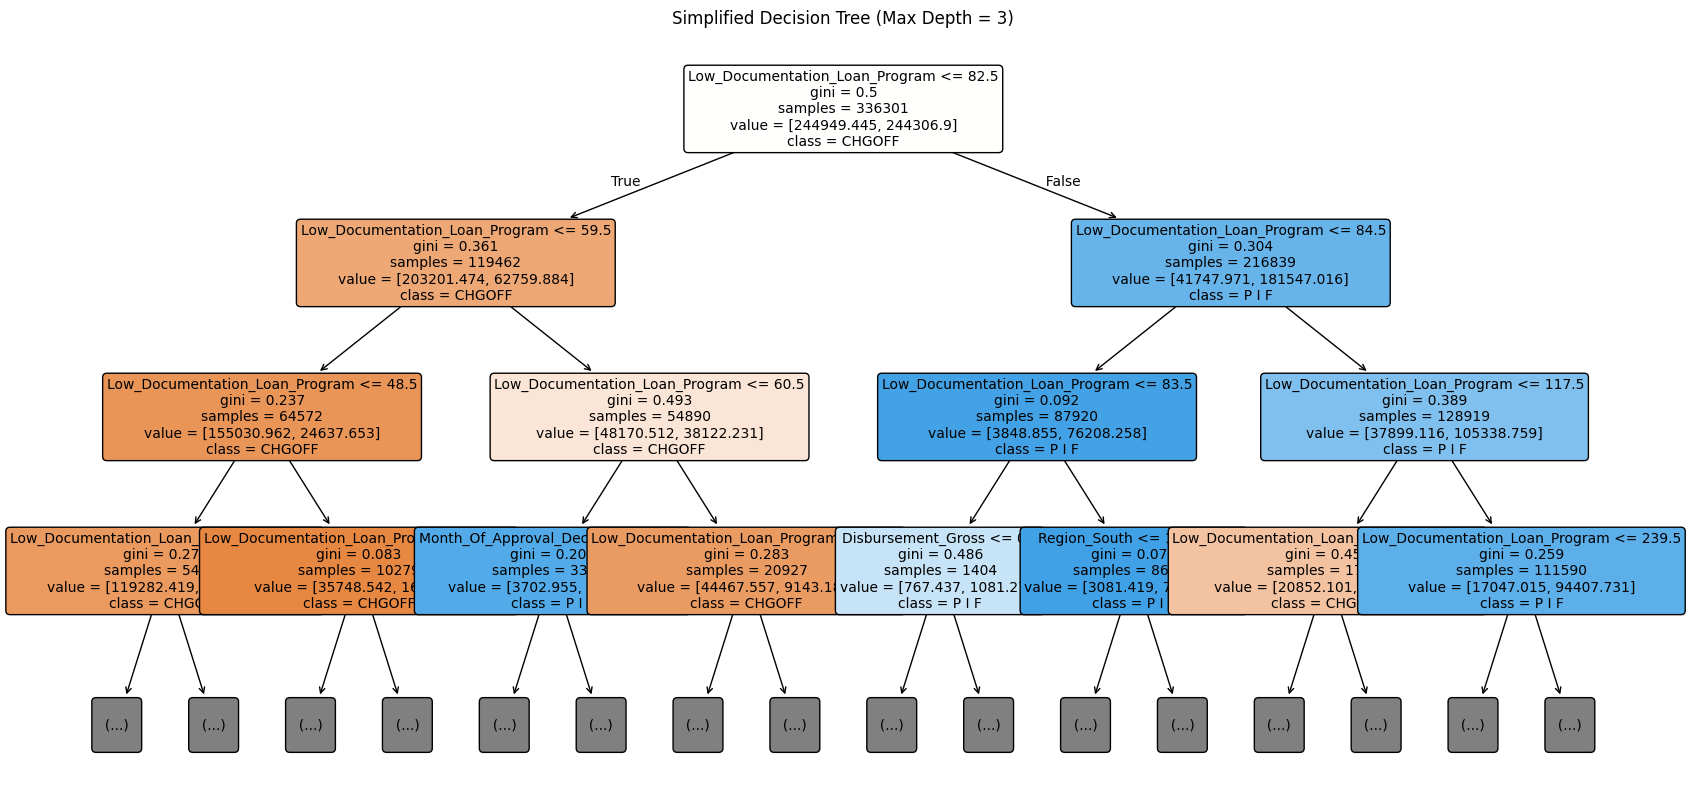

In [82]:
# Extract the first decision tree from the Bagging Classifier
first_tree = bagging_clf.estimators_[0]

# Plot the first decision tree with a limited depth (max_depth=3)
plt.figure(figsize=(20, 10))
plot_tree(
    first_tree,
    feature_names=X.columns, 
    class_names=['CHGOFF', 'P I F'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # Limit depth to 3
)

# Set a title for the plot
plt.title("Simplified Decision Tree (Max Depth = 3)")

# Show the plot
plt.show()

#### Implementing Boosting with XGBoost

In this section, we will implement **XGBoost**, a gradient boosting algorithm, to enhance model accuracy by building an ensemble of decision trees that iteratively correct errors.

- **XGBoost and Boosting:** XGBoost is a powerful boosting technique that combines the predictions of multiple weak learners (decision trees) to create a strong model. It focuses on the errors made by previous trees and adjusts accordingly, leading to better overall performance and predictive accuracy.

We will be experimenting with **GridSearchCV** to optimize the hyperparameters of the **XGBoost** model, focusing on the **learning_rate**. Grid search evaluates different parameter combinations to find the best one based on the **specificity_scorer** metric.

- **Hyperparameter Tuning**: We’ll test various values for **learning_rate** to find the optimal setting.
- **Cross-Validation**: Using **cv=5** ensures robust evaluation by training and testing on different data splits.
- **Parallel Execution**: **n_jobs=-1** speeds up the search by using all processors.

##### Experimenting with XGBoost Hyperparameters (No GridSearch)

Training Set Accuracy: 0.90
Training Set Precision: 0.98
Training Set Recall: 0.90
Training Set F1 Score: 0.94

Testing Set Accuracy: 0.90
Testing Set Precision: 0.98
Testing Set Recall: 0.90
Testing Set F1 Score: 0.93

Specificity (Training Set): 0.8995
Specificity (Test Set): 0.8903


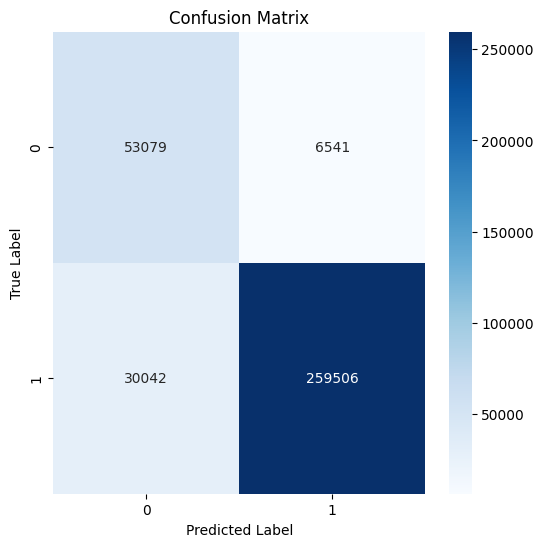

Total Net Profit/Loss: 2487332690.10
Average Total Net Profit/Loss: 7123.60


In [177]:
# Define your X (features) and y (target variable)
X = df_new_dummies.drop('Loan_Status', axis=1)  # Features excluding the target variable
y = df_new_dummies['Loan_Status']  # Target variable (Loan_Status)

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Set the parameters for the XGBoost model
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=500, 
    learning_rate=0.2, 
    scale_pos_weight=scale_pos_weight,
    min_child_weight=20,
    colsample_bytree=0.1,
    max_depth=25  # Using max_depth=25 as per your specification
)

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# Evaluate the model
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Print the metrics for the training and test sets
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}\n')

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=xgb_clf.classes_, yticklabels=xgb_clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate profit/loss for the results (as per the function you defined earlier)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Assuming you have a DataFrame 'df' with additional info like Disbursement_Gross
df_combined = df.join(results)  # Merge with results to calculate Profit/Loss
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate the average total net profit/loss
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Training Set Accuracy: 0.89
Training Set Precision: 0.97
Training Set Recall: 0.89
Training Set F1 Score: 0.93
Testing Set Accuracy: 0.89
Testing Set Precision: 0.97
Testing Set Recall: 0.89
Testing Set F1 Score: 0.93

Specificity (Training Set): 0.8882
Specificity (Test Set): 0.8827


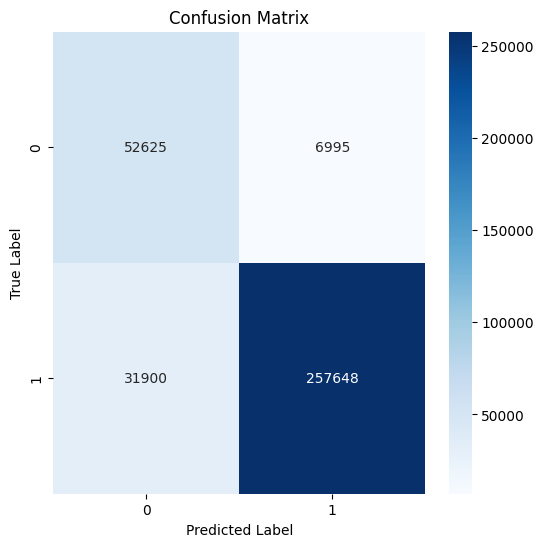

Total Net Profit/Loss: 2449958435.85
Average Total Net Profit/Loss: 7016.56


In [170]:
# Define your X (features) and y (target variable)
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)  # Features excluding the target variable
y = df_new_dropped_dummies['Loan_Status']  # Target variable (Loan_Status)

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Set the parameters for the XGBoost model
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=500, 
    learning_rate=0.2, 
    scale_pos_weight=scale_pos_weight,
    min_child_weight=20,
    colsample_bytree=0.1,
    max_depth=25  # Using max_depth=25 as per your specification
)

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# Evaluate the model
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Print the metrics for the training and test sets
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}')

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=xgb_clf.classes_, yticklabels=xgb_clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate profit/loss for the results (as per the function you defined earlier)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Assuming you have a DataFrame 'df' with additional info like Disbursement_Gross
df_combined = df.join(results)  # Merge with results to calculate Profit/Loss
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate the average total net profit/loss
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Both the **df_new_dummies** and **df_new_dropped_dummies** datasets performed well, with the **df_new_dummies** dataset achieving an average total net profit of $7123.60, slightly outperforming the other. Both datasets demonstrated strong predictive performance, but **df_new_dummies** showed a marginally better result.

##### Hyperparameter Tuning with Grid Search

The **param_grid dictionary** defines the hyperparameters we will tune for the XGBoost model:

- **learning_rate:** Controls the step size during training. We will test values of 0.1, 0.125, 0.15, and 0.175 to find the optimal rate for model accuracy.
- **min_child_weight:** Defines the minimum sum of weights required in a child node. We will test values of 15, 20, 25, and 30 to prevent overfitting and improve generalization.

We will use **GridSearchCV** with 5-fold cross-validation and the specificity scoring metric to find the best combination of these hyperparameters for improved model performance.

Best Parameters: {'learning_rate': 0.175, 'min_child_weight': 15}


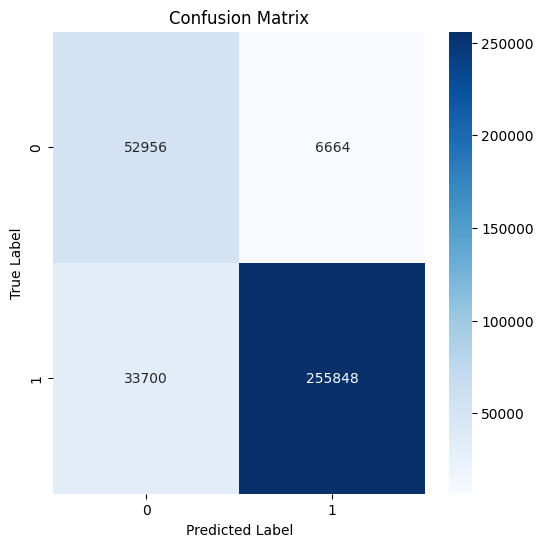

Training Set Accuracy: 0.89
Training Set Precision: 0.98
Training Set Recall: 0.89
Training Set F1 Score: 0.93

Testing Set Accuracy: 0.88
Testing Set Precision: 0.97
Testing Set Recall: 0.88
Testing Set F1 Score: 0.93

Specificity (Training Set): 0.8905
Specificity (Test Set): 0.8882

Total Net Profit/Loss: 1920211493.00
Average Total Net Profit/Loss: 5499.39


In [183]:
# Splitting the dataset
X = df_new_dummies.drop('Loan_Status', axis=1)
y = df_new_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Custom scoring metric for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Define and tune the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=300, 
    scale_pos_weight=scale_pos_weight,
    colsample_bytree=0.1
)  

param_grid = {
    'learning_rate': [0.1, 0.125, 0.15, 0.175],
    'min_child_weight': [15, 20, 25, 30]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=specificity_scorer,
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predictions and evaluations
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Training metrics
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

# Testing metrics
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}\n')

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}\n')

# Profit/Loss Calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge predictions with the original dataset
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
}).reset_index(drop=True)

# Ensure the original DataFrame (`df`) includes `Disbursement_Gross`
df_combined = df.join(results)  # Merge results with the original dataset on index or a common key

# Calculate profit/loss for each row
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate and print average net profit/loss per prediction
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Best Parameters: {'learning_rate': 0.15, 'min_child_weight': 25}


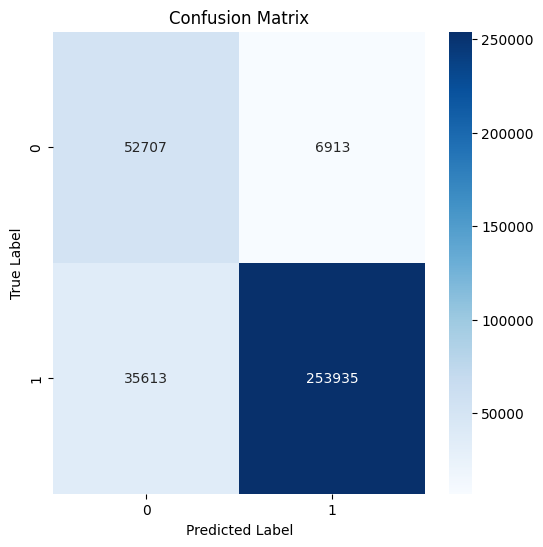

Training Set Accuracy: 0.88
Training Set Precision: 0.97
Training Set Recall: 0.88
Training Set F1 Score: 0.92

Testing Set Accuracy: 0.88
Testing Set Precision: 0.97
Testing Set Recall: 0.88
Testing Set F1 Score: 0.92

Specificity (Training Set): 0.8864
Specificity (Test Set): 0.8840

Total Net Profit/Loss: 1893695248.95
Average Total Net Profit/Loss: 5423.45


In [182]:
# Splitting the dataset
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Custom scoring metric for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Define and tune the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=300, 
    scale_pos_weight=scale_pos_weight,
    colsample_bytree=0.1
)  

param_grid = {
    'learning_rate': [0.1, 0.125, 0.15, 0.175],
    'min_child_weight': [15, 20, 25, 30]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=specificity_scorer,
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predictions and evaluations
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Training metrics
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

# Testing metrics
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}\n')

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}\n')

# Profit/Loss Calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge predictions with the original dataset
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
}).reset_index(drop=True)

# Ensure the original DataFrame (`df`) includes `Disbursement_Gross`
df_combined = df.join(results)  # Merge results with the original dataset on index or a common key

# Calculate profit/loss for each row
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate and print average net profit/loss per prediction
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Both models achieved an average total net profit of approximately $5,500, which shows a significant decrease compared to the performance of other models. This indicates that while both models performed decently, they did not perform as well as previous models in terms of profitability.

##### Updated Parameter Grid

We are using a learning rate of 0.2 to test if a higher learning rate helps the model converge faster and improve performance. This focuses on fine-tuning the learning rate without adding complexity from multiple parameters.

Best Parameters: {'learning_rate': 0.2}


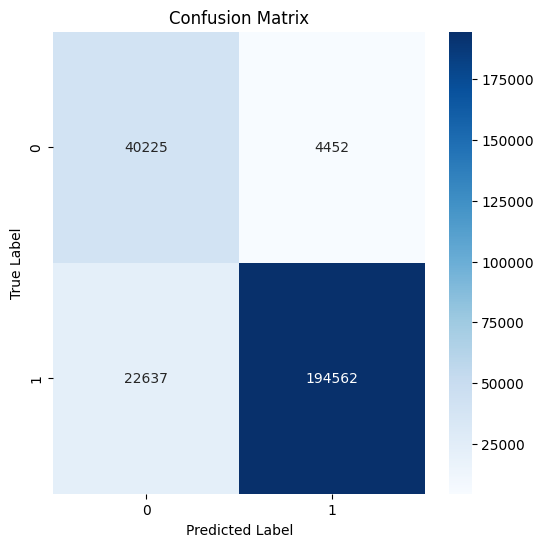

Training Set Accuracy: 0.90
Training Set Precision: 0.98
Training Set Recall: 0.90
Training Set F1 Score: 0.94
Testing Set Accuracy: 0.90
Testing Set Precision: 0.98
Testing Set Recall: 0.90
Testing Set F1 Score: 0.93


Specificity (Training Set): 0.9088
Specificity (Test Set): 0.9004

Total Net Profit/Loss: 1873338070.30
Average Total Net Profit/Loss: 7153.53


In [206]:
# Splitting the dataset
X = df_new_dummies.drop('Loan_Status', axis=1)
y = df_new_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)
accuracy_scorer = make_scorer(accuracy_score)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Updated XGBoost classifier with new parameters
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=500, 
    scale_pos_weight=scale_pos_weight,
    min_child_weight=20,
    colsample_bytree=0.1,
    max_depth=25  # Best for specificity
)  

# Updated parameter grid
param_grid = {
    'learning_rate': [0.2],
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=specificity_scorer,   # Change this to a metric suitable for your task
    cv=5,                         # Number of cross-validation folds
    verbose=0,                    # Increase verbosity to see progress
    n_jobs=-1                     # Use all processors for parallel execution
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}')

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}\n')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}\n')

# Profit/Loss calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Create results DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Merge df_new and results on the index or appropriate column (if there's a common key)
df_combined = df.join(results)

# Apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate the average profit/loss per prediction
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Best Parameters: {'learning_rate': 0.2}


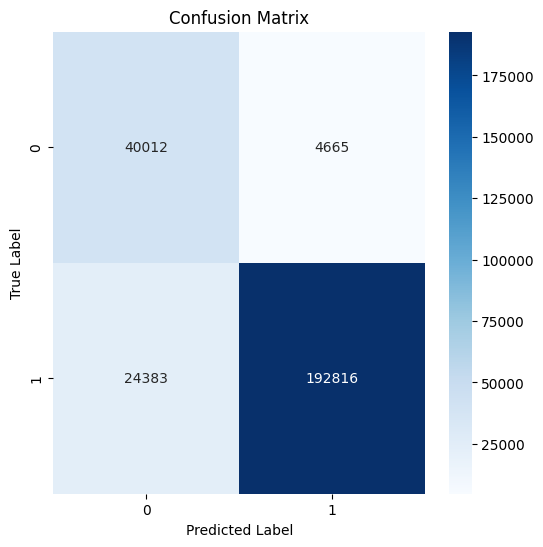

Training Set Accuracy: 0.89
Training Set Precision: 0.98
Training Set Recall: 0.89
Training Set F1 Score: 0.93
Testing Set Accuracy: 0.89
Testing Set Precision: 0.98
Testing Set Recall: 0.89
Testing Set F1 Score: 0.93

Specificity (Training Set): 0.9008
Specificity (Test Set): 0.8956

Total Net Profit/Loss: 1846558362.10
Average Total Net Profit/Loss: 7051.27


In [212]:
# Splitting the dataset
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)
accuracy_scorer = make_scorer(accuracy_score)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Updated XGBoost classifier with new parameters
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=500, 
    scale_pos_weight=scale_pos_weight,
    min_child_weight=20,
    colsample_bytree=0.1,
    max_depth=25  # Best for specificity
)  

# Updated parameter grid
param_grid = {
    'learning_rate': [0.2],
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=specificity_scorer,   # Change this to a metric suitable for your task
    cv=5,                         # Number of cross-validation folds
    verbose=0,                    # Increase verbosity to see progress
    n_jobs=-1                     # Use all processors for parallel execution
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}')

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')

# Confusion Matrix and Specificity
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}\n')

# Profit/Loss calculation
def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Create results DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Merge df_new and results on the index or appropriate column (if there's a common key)
df_combined = df.join(results)

# Apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss
total_net = df_combined['Profit_Loss'].sum()
print(f"Total Net Profit/Loss: {total_net:.2f}")

# Calculate the average profit/loss per prediction
average_total_net = total_net / results.shape[0]
print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Both models performed well with this adjustment, achieving an average net profit of over $7,000. This indicates that the change in the learning rate had a positive impact, improving the models' profitability compared to previous configurations.

In our boosting experiments, the **df_new_dummies** dataset outperformed the **df_new_dropped_dummies** dataset. Despite both datasets showing strong performance, the inclusion of dummy variables in **df_new_dummies** provided better predictive power, leading to higher average net profits. This suggests that keeping the additional features encoded as dummy variables helped improve the model's ability to learn and make more accurate predictions.

#### Single Tree Classifier Performance Metrics

In [190]:
# Split data into features and target
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=20,
    random_state=42,
    max_leaf_nodes=150,
    class_weight='balanced',
)
clf.fit(X_train, y_train)

# Make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

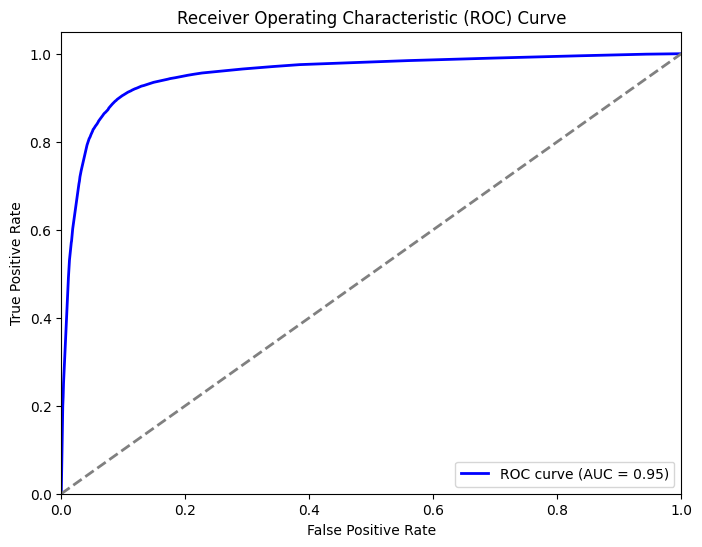

In [192]:
# Get predicted probabilities for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

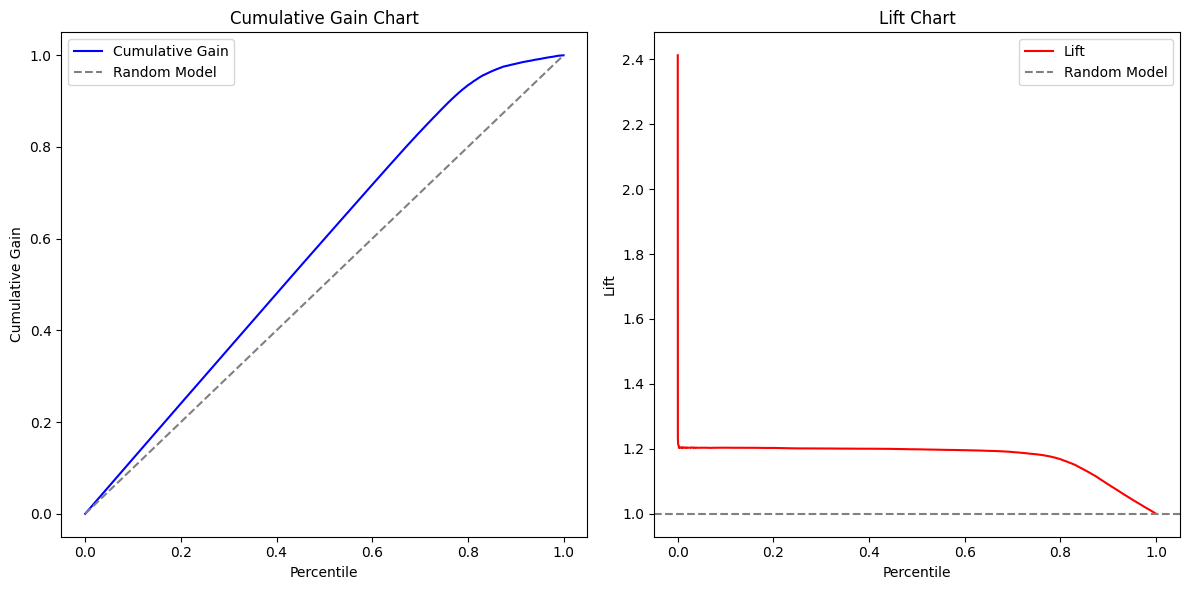

In [194]:
# Get predicted probabilities for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
results = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Prob': y_prob
})

# Sort by predicted probabilities in descending order
results = results.sort_values(by='Pred_Prob', ascending=False)

# Calculate cumulative gain (cumulative percentage of positive cases)
results['Cumulative_Positive'] = results['True_Label'].cumsum()
total_positive = results['True_Label'].sum()
results['Cumulative_Gain'] = results['Cumulative_Positive'] / total_positive

# Calculate Lift: (Cumulative Gain) / (Percentile Rank)
results['Percentile'] = np.linspace(0, 1, len(results))
results['Lift'] = results['Cumulative_Gain'] / results['Percentile']

# Plot Lift and Gain
plt.figure(figsize=(12, 6))

# Plot Cumulative Gain
plt.subplot(1, 2, 1)
plt.plot(results['Percentile'], results['Cumulative_Gain'], color='blue', label='Cumulative Gain')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Model')
plt.xlabel('Percentile')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart')
plt.legend()

# Plot Lift
plt.subplot(1, 2, 2)
plt.plot(results['Percentile'], results['Lift'], color='red', label='Lift')
plt.axhline(1, color='gray', linestyle='--', label='Random Model')
plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()

plt.tight_layout()
plt.show()

#### Bagging Random Forest Performance Metrics

In [157]:
# Splitting the dataset
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Bagging Classifier with Decision Tree as base estimator
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=20,
        random_state=42,
        max_leaf_nodes=150,
        class_weight='balanced'
    ),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.7,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=True,
    random_state=42
)

# Fit the model
bagging_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=20,
                                                   max_leaf_nodes=150,
                                                   random_state=42),
                  max_features=0.7, max_samples=0.8, n_estimators=50,
                  oob_score=True, random_state=42)

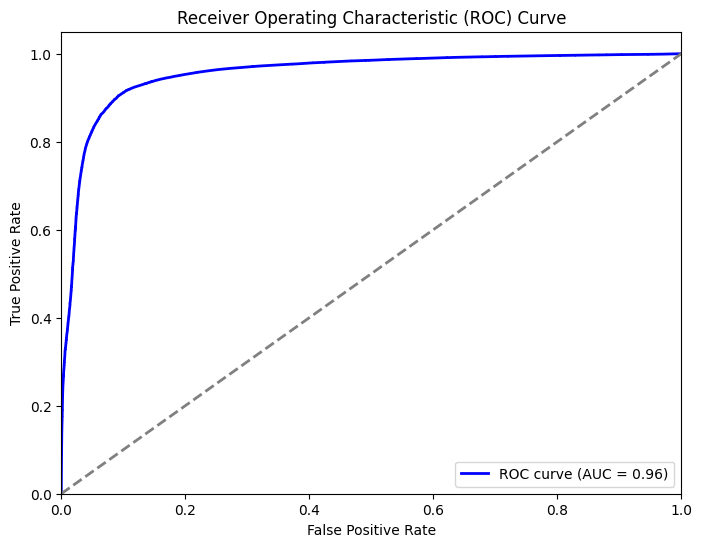

In [162]:
# Get predicted probabilities for the positive class
y_prob = bagging_clf.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

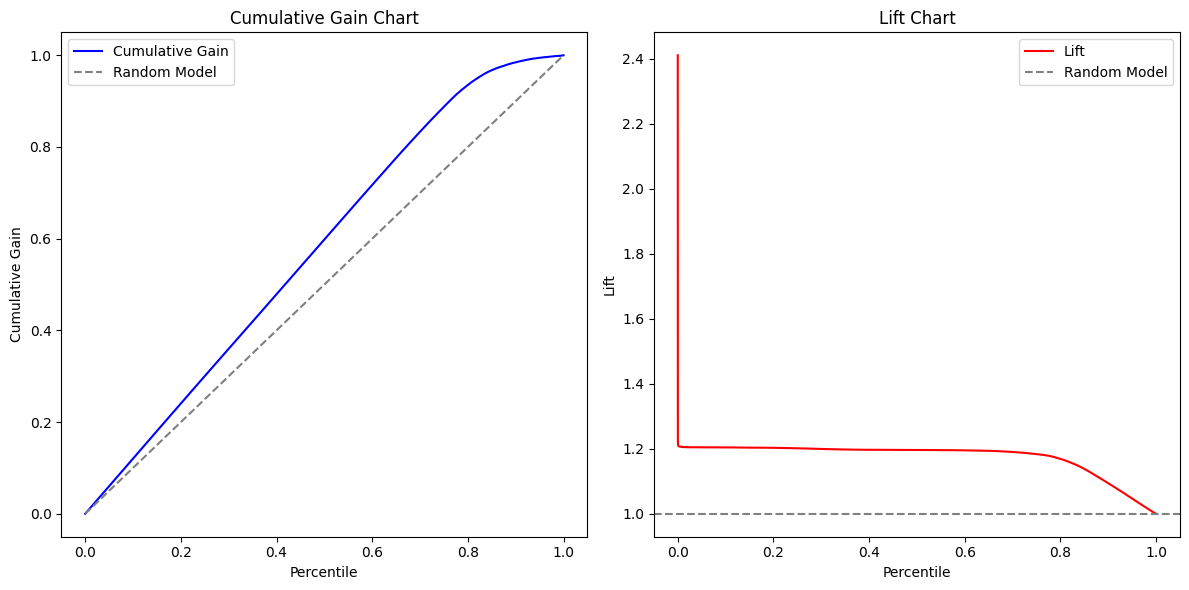

In [164]:
# Get predicted probabilities for the positive class
y_prob = bagging_clf.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
results = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Prob': y_prob
})

# Sort by predicted probabilities in descending order
results = results.sort_values(by='Pred_Prob', ascending=False)

# Calculate cumulative gain (cumulative percentage of positive cases)
results['Cumulative_Positive'] = results['True_Label'].cumsum()
total_positive = results['True_Label'].sum()
results['Cumulative_Gain'] = results['Cumulative_Positive'] / total_positive

# Calculate Lift: (Cumulative Gain) / (Percentile Rank)
results['Percentile'] = np.linspace(0, 1, len(results))
results['Lift'] = results['Cumulative_Gain'] / results['Percentile']

# Plot Lift and Gain
plt.figure(figsize=(12, 6))

# Plot Cumulative Gain
plt.subplot(1, 2, 1)
plt.plot(results['Percentile'], results['Cumulative_Gain'], color='blue', label='Cumulative Gain')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Model')
plt.xlabel('Percentile')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart')
plt.legend()

# Plot Lift
plt.subplot(1, 2, 2)
plt.plot(results['Percentile'], results['Lift'], color='red', label='Lift')
plt.axhline(1, color='gray', linestyle='--', label='Random Model')
plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()

plt.tight_layout()
plt.show()

#### Boosting with XGB Performance Metrics

In [196]:
# Splitting the dataset
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)
y = df_new_dropped_dummies['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)
accuracy_scorer = make_scorer(accuracy_score)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Updated XGBoost classifier with new parameters
xgb_clf = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=500, 
    scale_pos_weight=scale_pos_weight,
    min_child_weight=20,
    colsample_bytree=0.1,
    max_depth=25  # Best for specificity
)  

# Updated parameter grid
param_grid = {
    'learning_rate': [0.2],
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=specificity_scorer,   # Change this to a metric suitable for your task
    cv=5,                         # Number of cross-validation folds
    verbose=0,                    # Increase verbosity to see progress
    n_jobs=-1                     # Use all processors for parallel execution
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.1, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=25,
                                     max_leaves=None, min_child_weight=20,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1, param_grid={'learning_rate': [0.2]},
             scoring=make_scorer(specificity_score, response_method='predict'))

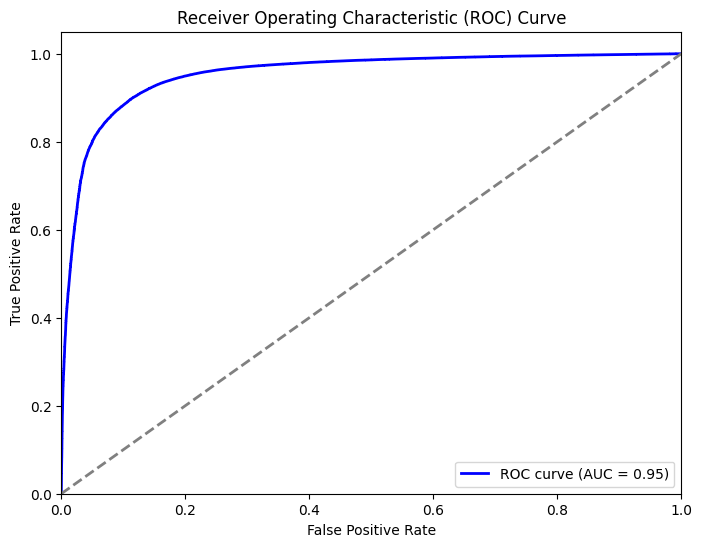

In [202]:
# Get predicted probabilities for the positive class
y_prob = grid_search.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

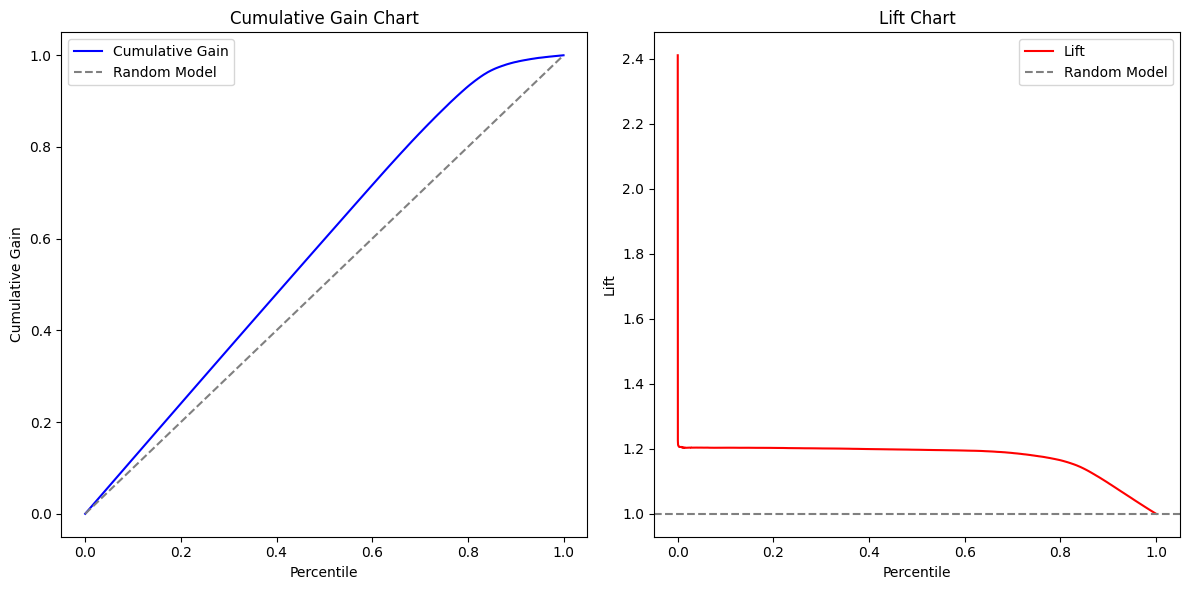

In [204]:
# Get predicted probabilities for the positive class
y_prob = grid_search.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
results = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Prob': y_prob
})

# Sort by predicted probabilities in descending order
results = results.sort_values(by='Pred_Prob', ascending=False)

# Calculate cumulative gain (cumulative percentage of positive cases)
results['Cumulative_Positive'] = results['True_Label'].cumsum()
total_positive = results['True_Label'].sum()
results['Cumulative_Gain'] = results['Cumulative_Positive'] / total_positive

# Calculate Lift: (Cumulative Gain) / (Percentile Rank)
results['Percentile'] = np.linspace(0, 1, len(results))
results['Lift'] = results['Cumulative_Gain'] / results['Percentile']

# Plot Lift and Gain
plt.figure(figsize=(12, 6))

# Plot Cumulative Gain
plt.subplot(1, 2, 1)
plt.plot(results['Percentile'], results['Cumulative_Gain'], color='blue', label='Cumulative Gain')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Model')
plt.xlabel('Percentile')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart')
plt.legend()

# Plot Lift
plt.subplot(1, 2, 2)
plt.plot(results['Percentile'], results['Lift'], color='red', label='Lift')
plt.axhline(1, color='gray', linestyle='--', label='Random Model')
plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()

plt.tight_layout()
plt.show()

#### K-Fold Cross-Validation for Bagging Random Forest

In [224]:
# Splitting the dataset
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)  # Features excluding the target variable
y = df_new_dropped_dummies['Loan_Status']  # Target variable (Loan_Status)

# Initialize Bagging Classifier with Decision Tree as base estimator
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=20,
        random_state=42,
        max_leaf_nodes=150,
        class_weight='balanced'  # Handles the class imbalance in target variable
    ),
    n_estimators=50,  # Number of trees
    max_samples=0.8,  # Fraction of samples used for each tree
    max_features=0.7,  # Fraction of features used for each tree
    bootstrap=True,  # Sample with replacement
    bootstrap_features=False,  # Do not sample features with replacement
    oob_score=True,  # Out-of-bag evaluation score
    random_state=42
)

# Perform K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
precisions = []
recalls = []
f1_scores = []
accuracies = []
specificities = []

# Cross-validation loop
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    bagging_clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = bagging_clf.predict(X_test)

    # Calculate the metrics for each fold
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Specificity calculation (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)  # Specificity = TN / (TN + FP)

    # Append metrics for each fold
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(accuracy)
    specificities.append(specificity)

# Calculate the average metrics across all folds
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracies)
avg_specificity = np.mean(specificities)

# Output the metrics for each fold
print("Metrics for each fold:")
for i in range(kfold.get_n_splits()):
    print(f"Fold {i+1} - Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1 Score: {f1_scores[i]:.4f}, Accuracy: {accuracies[i]:.4f}, Specificity: {specificities[i]:.4f}")

# Output the average metrics
print("\nAverage Metrics across all folds:")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

Metrics for each fold:
Fold 1 - Precision: 0.9787, Recall: 0.9060, F1 Score: 0.9409, Accuracy: 0.9057, Specificity: 0.9046
Fold 2 - Precision: 0.9785, Recall: 0.9078, F1 Score: 0.9418, Accuracy: 0.9070, Specificity: 0.9035
Fold 3 - Precision: 0.9787, Recall: 0.9078, F1 Score: 0.9419, Accuracy: 0.9072, Specificity: 0.9044
Fold 4 - Precision: 0.9788, Recall: 0.9056, F1 Score: 0.9408, Accuracy: 0.9056, Specificity: 0.9052
Fold 5 - Precision: 0.9790, Recall: 0.9073, F1 Score: 0.9418, Accuracy: 0.9070, Specificity: 0.9057

Average Metrics across all folds:
Average Precision: 0.9788
Average Recall: 0.9069
Average F1 Score: 0.9415
Average Accuracy: 0.9065
Average Specificity: 0.9047


After performing **K-Fold cross-validation**, we observed that the performance metrics (**precision**, **recall**, **F1 score**, **accuracy**, and **specificity**) remained consistent across all folds. This consistency suggests that our model is generalizing well to different subsets of the data and is not overfitting.

#### Finding the Top Companies Based on Net Profit and Success Rate

In this analysis, we will identify the top companies by evaluating both their success rate and total net profit. By considering these two key performance indicators, we aim to determine which companies excel in both profitability and overall success.

In [324]:
df['NAICS_U.S._Industry_Title'] = df_new['NAICS_U.S._Industry_Title']

In [326]:
df

,Name,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status,Month_Of_Approval,NAICS_U.S._Industry_Title
0,ABC HOBBYCRAFT,84,4,New,Unknown,0,1,60000,1,Midwest,0,February,RetailTrade
1,LANDMARK BAR & GRILLE (THE),60,2,New,Unknown,0,1,40000,1,Midwest,0,February,Accommodation_FoodServices
2,"WHITLOCK DDS, TODD M.",180,7,Existing,Unknown,0,0,287000,1,Midwest,0,February,HealthCare_SocialAssistance
3,"BIG BUCKS PAWN & JEWELRY, LLC",60,2,Existing,Unknown,0,1,35000,1,South,0,February,Unknown
4,"ANASTASIA CONFECTIONS, INC.",240,14,Existing,Unknown,0,0,229000,1,South,0,February,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,FABRIC FARMS,60,6,Existing,Unknown,0,0,70000,1,Midwest,0,February,RetailTrade
872915,FABRIC FARMS,60,6,Existing,Unknown,1,0,85000,1,Midwest,0,February,RetailTrade
872916,"RADCO MANUFACTURING CO.,INC.",108,26,Existing,Unknown,0,0,300000,1,West,0,February,Manufacturing
872917,"MARUTAMA HAWAII, INC.",60,6,Existing,Unknown,0,1,75000,0,West,0,February,Unknown


In [354]:
# Add derived columns for faster computation
df['PIF'] = (df['Loan_Status'] == 1).astype(int)  # 1 if Loan_Status is 1, else 0
df['Net_Profit_Per_Loan'] = df['Disbursement_Gross'] * df['PIF'] * 0.05 - \
                            df['Disbursement_Gross'] * (1 - df['PIF']) * 0.25

# Group and aggregate
top_net_profit_companies = (
    df.groupby(['Name'], as_index=False)
      .agg(
          Loan_Count=('Loan_Status', 'count'),
          PIF_Count=('PIF', 'sum'),
          Success_Rate=('PIF', 'mean'),  # Success rate = PIF_Count / Loan_Count
          Net_Profit=('Net_Profit_Per_Loan', 'sum')
      )
)

# Define bins and labels for the 'Loan_Approval' column using pd.cut
bins = [0.0, 0.8, 0.9, 0.95, 1]
labels = ['Low', 'Moderate', 'High', 'Very High']

# Apply pd.cut to 'PIF_Success_Rate' for top_net_profit_companies and handle PIF_Success_Rate == 0
top_net_profit_companies['Loan_Approval'] = top_net_profit_companies['Success_Rate'].apply(
    lambda x: 'Very Low' if x == 0 else pd.cut([x], bins=bins, labels=labels)[0]
)

# Sort by Net Profit in descending order
top_net_profit_companies = top_net_profit_companies.sort_values(by='Net_Profit', ascending=False)

In [363]:
top_net_profit_companies

,Name,Loan_Count,PIF_Count,Success_Rate,Net_Profit,Loan_Approval
311047,HOLIDAY INN EXPRESS,216,215,0.995370,11062789.75,Very High
147906,COMFORT INN,211,210,0.995261,10297577.95,Very High
186326,DAYS INN,245,235,0.959184,8098266.55,Very High
641786,SUPER 8 MOTEL,235,227,0.965957,7179551.65,Very High
637231,SUBWAY,1253,1188,0.948125,5920272.30,High
...,...,...,...,...,...,...
598750,SCHLOTZSKY'S DELI,176,145,0.823864,-1282106.80,Moderate
520638,PETLAND,50,31,0.620000,-1325600.75,Low
317486,HUNTINGTON LEARNING CENTER,96,62,0.645833,-1609438.75,Low
526365,PLANET BEACH,96,51,0.531250,-1863132.95,Low


In [365]:
# Save the DataFrame to a CSV file
file_path = 'top_net_profit_companies.csv'
top_net_profit_companies.to_csv(file_path, index=False)

# Provide a link to download the file
FileLink(file_path)

/Users/brandonchang/CSU Competition/Final Notebooks/top_net_profit_companies.csv

The dataframe **top_net_profit_companies** lists companies in descending order based on both their success rate and net profit. Additionally, it includes a column that categorizes the likelihood of the company repaying a loan, binned into categories: ['Very Low', 'Low', 'Moderate', 'High', 'Very High']. This feature provides insight into the probability of loan repayment for each company. If the bank cannot use the model for detailed analysis, they can quickly reference this spreadsheet to check if a company has previously applied for a loan and the associated probability of repayment.

#### Conclusions

In this analysis, we evaluated two different datasets, **df_new_dummies** and **df_new_dropped_dummies**, across various machine learning models. Upon comparison, **df_new_dummies** outperformed **df_new_dropped_dummies** in both single tree and random forest models. However, **df_new_dropped_dummies** demonstrated superior performance when using XGBoost.

Despite these differences, the best model, based on the total average net profit, was **Bagging Random Forest**, achieving an impressive average net profit of $7452.13. While all models generated good profits, this model stood out with the highest performance in terms of profitability.

Key takeaways include:
- **Class Imbalance Handling:** Addressing the class imbalance in the target variable, Loan_Status, by using balanced classes significantly improved model performance. This adjustment ensured better predictions for both minority and majority classes.
- **Profitability Focus:** The Bagging Random Forest model was the most profitable, surpassing other models and yielding a higher net profit, even when compared to more complex algorithms like XGBoost.
- **AUC Score:** The **AUC score** of **0.96** indicates that our final model has excellent classification performance, providing a high level of confidence in distinguishing between the classes (loan approval vs. rejection).
- **Comparison with Other Models:** Compared to **Neural Networks**, **KNN**, **Logistic Regression**, and **Discriminant Analysis**, the **Bagging Random Forest** emerged as the best model in terms of both profitability and performance metrics, including the AUC curve.

Overall, while different datasets performed better with different algorithms, the **Bagging Random Forest** model on **df_new_dropped_dummies** proved to be the most effective, making it the best choice for this particular use case.